# Approximating Lévy Stable log density

In [1]:
import math
import functools
import numpy as np
from scipy.stats import levy_stable
import scipy.special
import torch
import pyro.distributions as dist
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

torch.set_default_tensor_type(torch.DoubleTensor)
mpl.rcParams['axes.linewidth'] = 0.1
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levy_stable.html
# levy_stable.parameterization = "S0"

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning,
                        message=".*divide by zero encountered.*")
warnings.filterwarnings("ignore", category=RuntimeWarning,
                        message=".*invalid value encountered in arctanh.*")

## Building intuition

Helpful sigmoid functions.

In [2]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))
def logit(x):
    return np.log(x) - np.log1p(-x)

def _():
    x = np.linspace(-10, 10, 100)
    assert np.allclose(x, logit(sigmoid(x)))
_()

Converting between the two most common parametrizations of the Levy stable distribution.

In [3]:
def S0_to_S1(a, b, x):
    assert isinstance(a, (int, float))
    return x if a == 1 else x + b * np.tan(np.pi / 2 * a)

def S1_to_S0(a, b, z):
    assert isinstance(a, (int, float))
    return z if a == 1 else z - b * np.tan(np.pi / 2 * a)

We eventually want to model a log density function `Stable(a,b).log_prob(x)` or equivalently a cdf $: (0,2) \times [-1,1] \times \mathbb R \to [0,1]$.

In [4]:
a_grid = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
b_grid = [0.0, 0.2, 0.5, 0.8, 0.9, 1.0]
x_grid = [-10.0, -1.0, -0.1, 0.0, 0.1, 1.0, 10.0]

Let's build up some intuition by visualizing the density on a transformed real line `x = atanh(reals)`.

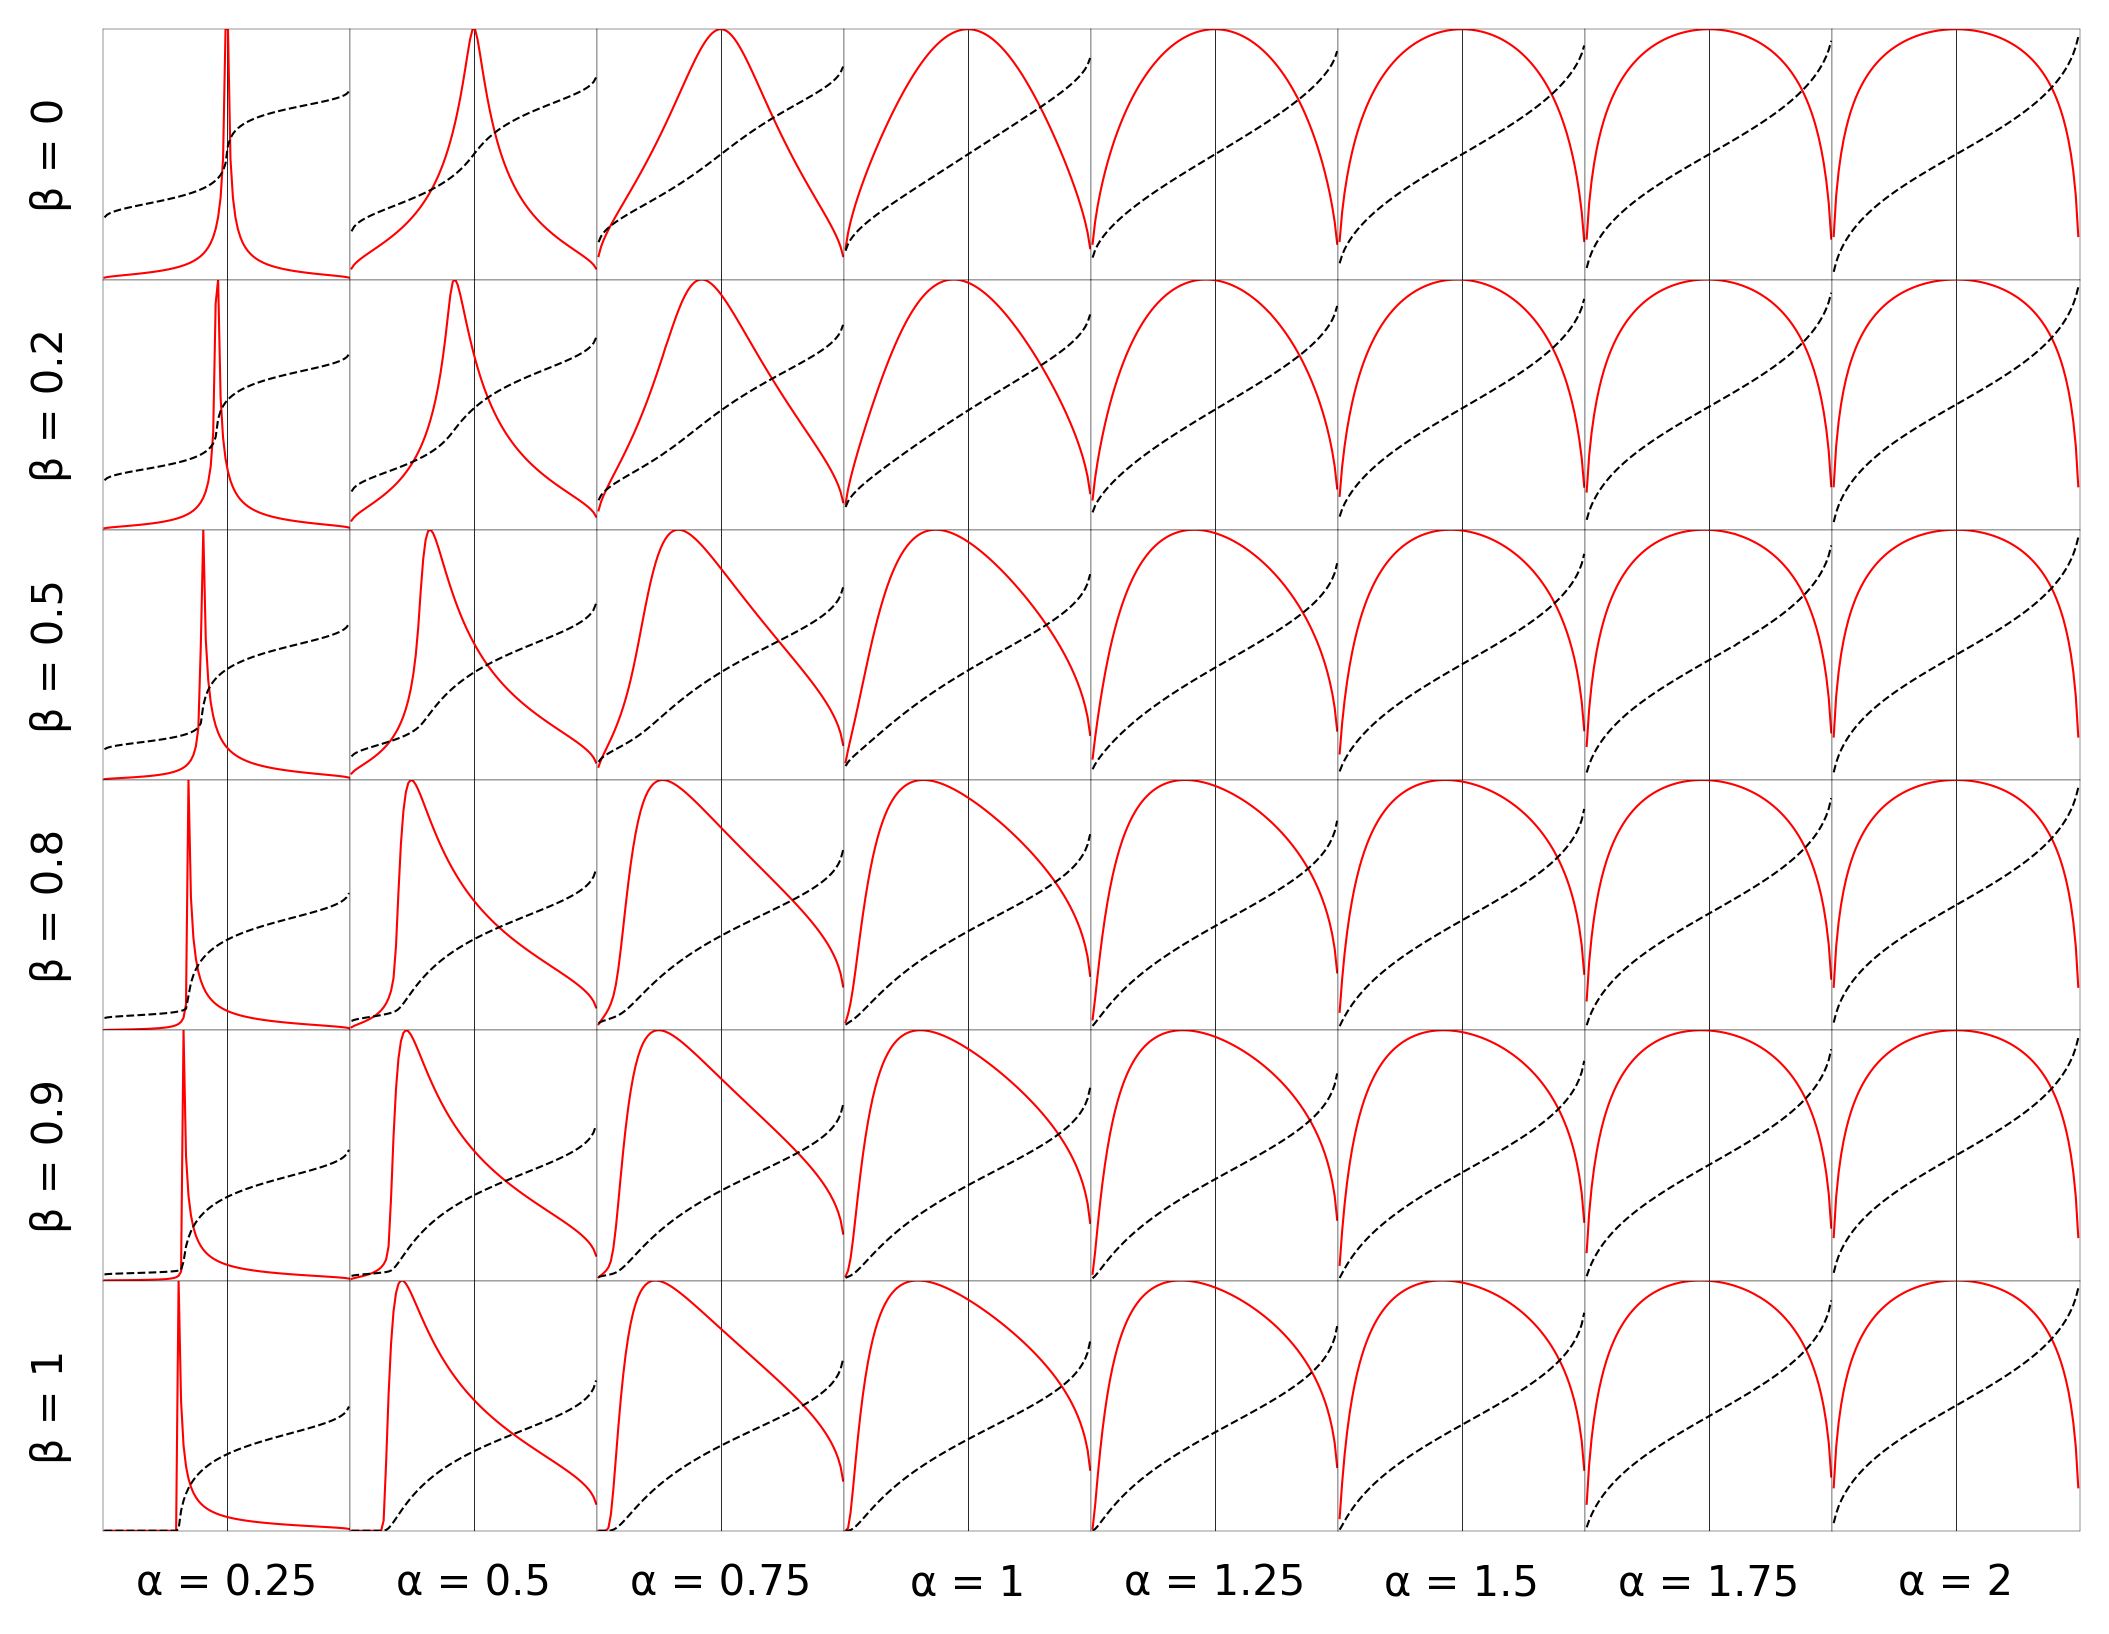

In [5]:
def plot_density(n=100):
    u = np.linspace(1/n - 1, 1 - 1/n, n)
    x = np.arctanh(u)
    fig, axes = plt.subplots(
        len(b_grid), len(a_grid), sharex=True, sharey=True,
        figsize=(0.5 + len(a_grid), 0.5 + len(b_grid)), dpi=300)
    for i, b in enumerate(b_grid):
        for j, a in enumerate(a_grid):
            ax = axes[i][j]
            ax.axvline(0, lw=0.2, color="k")
            # Convert from S0 to Scipy's S1 coordinates.
            # Note that scipy.stasts.levy_stable.parameterization
            # appears not to be configurable from the default S1.
            z = S0_to_S1(a, b, x)
            p = levy_stable(a, b).pdf(z)
            p /= p.max()
            ax.plot(u, p, "r-", lw=0.5)
            c = levy_stable(a, b).cdf(z)
            ax.plot(u, c, "k--", lw=0.5)
            ax.set_xlim(-1, 1)
            ax.set_ylim(0, 1)
            ax.set_xticks(())
            ax.set_yticks(())
            if i == len(b_grid) - 1:
                ax.set_xlabel(f"α = {a:0.3g}")
            if j == 0:
                ax.set_ylabel(f"β = {b:0.3g}")
    plt.subplots_adjust(hspace=0, wspace=0)
plot_density()

And let's sanity check to ensure we have the right paraemeterization.

In [6]:
def plot_hist(a, b, n=100, num_samples=10000, bins=31):
    # True density.
    u = np.linspace(1/n - 1, 1 - 1/n, n)
    x = np.arctanh(u)
    z = S0_to_S1(a, b, x)
    plt.axvline(0, lw=0.2, color="k")
    p = levy_stable(a, b).pdf(z) / (1 - u**2)
    # p /= p.max()
    plt.plot(u, p, "r-", lw=0.5)
    
    # Empirical density.
    x = dist.Stable(a, b).sample([num_samples]).numpy()
    u = np.tanh(x)
    plt.hist(u, bins=np.linspace(-1.0, 1.0, bins), density=True)
    
    # Empirical density.
    z = levy_stable(a, b).rvs(num_samples)
    x = S1_to_S0(a, b, z)
    u = np.tanh(x)
    plt.hist(u, color="red", alpha=0.5, bins=np.linspace(-1.0, 1.0, bins), density=True)
    
    plt.xlim(-1, 1)
    plt.ylim(0, 1)
    plt.xticks(())
    plt.yticks(())

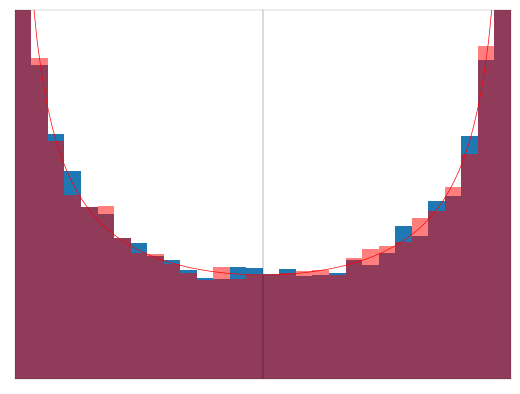

In [7]:
plot_hist(1.99, 0.0)

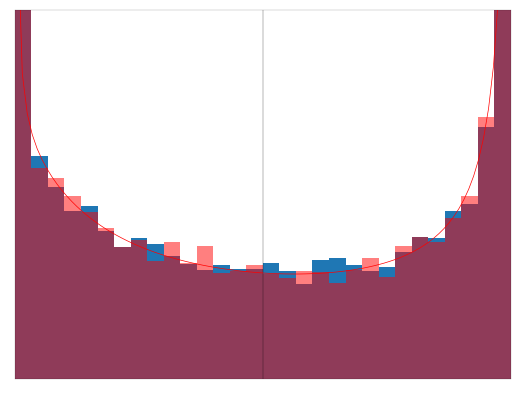

In [8]:
plot_hist(1.25, 0.5)

## Approximation

Now let's try to make the cdf easier to approximate by transforming both the x and y axes while preserving the asymptotic power law behavior of tails, namely that ([Nolan (2020)](https://edspace.american.edu/jpnolan/stable/) ss. 1.5 pp. 13 thm. 1.2) if $X\sim S(\alpha,\beta,\gamma,\delta;0)$ then
$$
P(X > x) \sim \gamma^\alpha c_\alpha (1+\beta) x^{-\alpha}
$$
where we assume wlog standard parameters $\gamma=1$ and $\delta=0$, and define
$$
c_\alpha = \sin\left(\frac {\pi\alpha} 2\right) \frac {\Gamma(\alpha)} \pi
$$

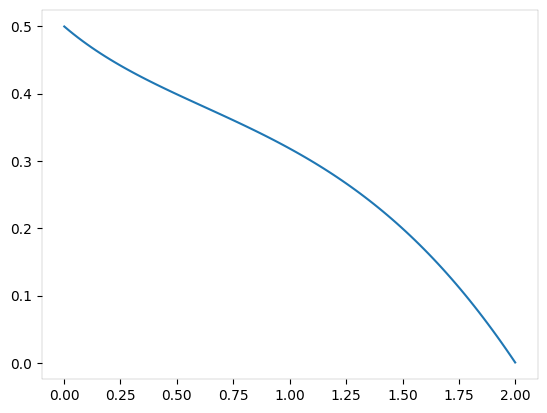

In [9]:
def plot_ca(eps=1e-3):
    a = np.linspace(0 + eps, 2 - eps, 100)
    ca = np.sin(np.pi * a / 2) * scipy.special.gamma(a) / np.pi
    plt.plot(a, ca)
plot_ca()

We want to approach the three asymptotes, in value (cdf) and in formal first derivative (pdf):
\begin{align*}
\text{As }\alpha\nearrow 2\!:&\quad
  u(x) \approx \operatorname{erf}(x/2)
\\
\text{As }x\nearrow\infty\!:&\quad
  u(x) \approx 1 - 2 c_\alpha(1+\beta)x(u)^{-\alpha}
\\
\text{As }x\searrow-\infty\!:&\quad
  u(x) \approx 2 c_\alpha(1-\beta)(-x(u))^{-\alpha} - 1
\end{align*}

### Symmetric case

Following the equation $x^\alpha=\exp(\alpha\log x)$, consider a symmetrized version replacing $\exp$ with `tanh` and $\log$ with `arcsinh`, yielding a sigmoid function with correct tails:
$$
  u(x) = \operatorname{tanh}\left(\alpha \operatorname{asinh}\left(x f(\alpha,\beta)\right) + g(\alpha,\beta)\right)
$$

In [10]:
def plot_symmetric(u_of_x, n=200):
    assert u_of_x.__name__ == "u_of_x"
    x = np.logspace(-2, 6, n)
    # x = np.concatenate([-np.flip(x), np.logspace(-2, 5, n)])
    fig, axes = plt.subplots(1, len(a_grid), figsize=(8,1.5), dpi=300, sharex=True, sharey=True)
    for i, (a, ax) in enumerate(zip(a_grid, axes)):
        u = u_of_x(a, x)
        c = levy_stable(a, 0).cdf(x) * 2 - 1
        ax.plot(x, np.arctanh(c), "k--", lw=1)
        if isinstance(u, dict):
            for label, u in u.items():
                ax.plot(x, np.arctanh(u), lw=1, label=label)
            if i == 0:
                ax.legend(loc="lower right", fontsize=8)
        else:
            ax.plot(x, np.arctanh(u), "r-", lw=1)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(fr"$\alpha$={a:0.2f}", fontsize="small")
    plt.subplots_adjust(hspace=0, wspace=0)

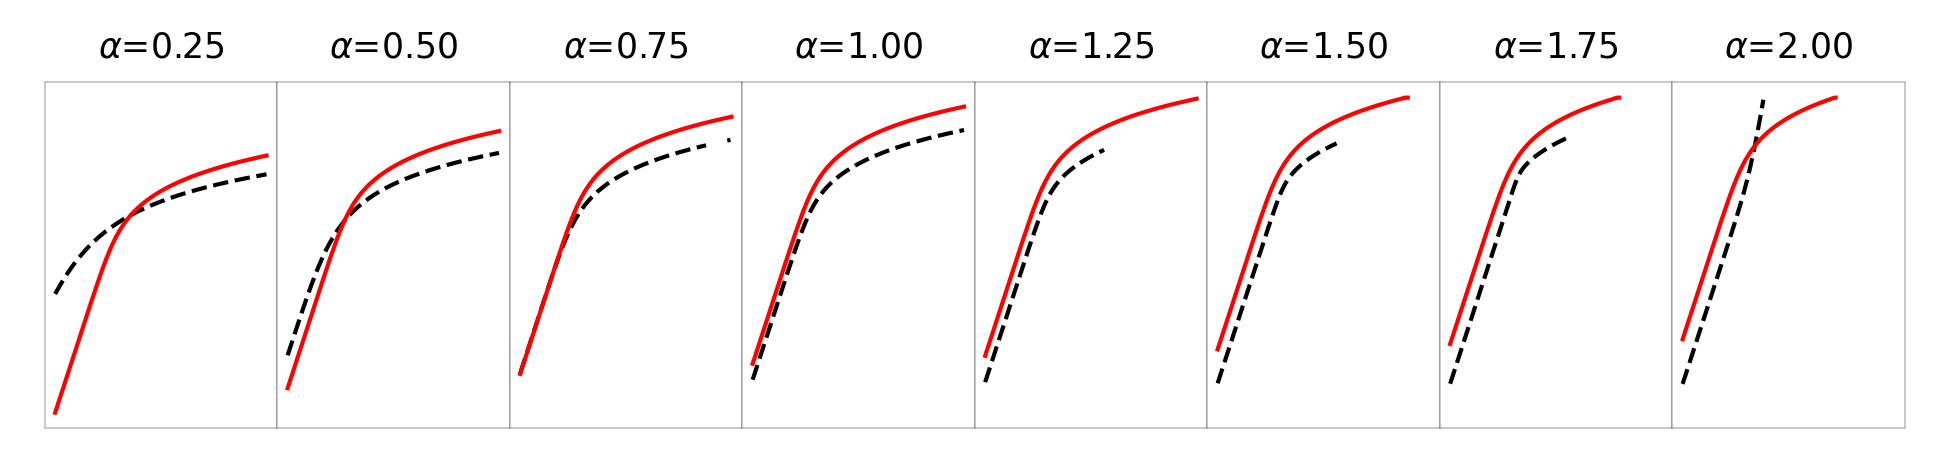

In [11]:
@plot_symmetric
def u_of_x(a, x):
    u = np.tanh(a * np.arcsinh(x))
    return u

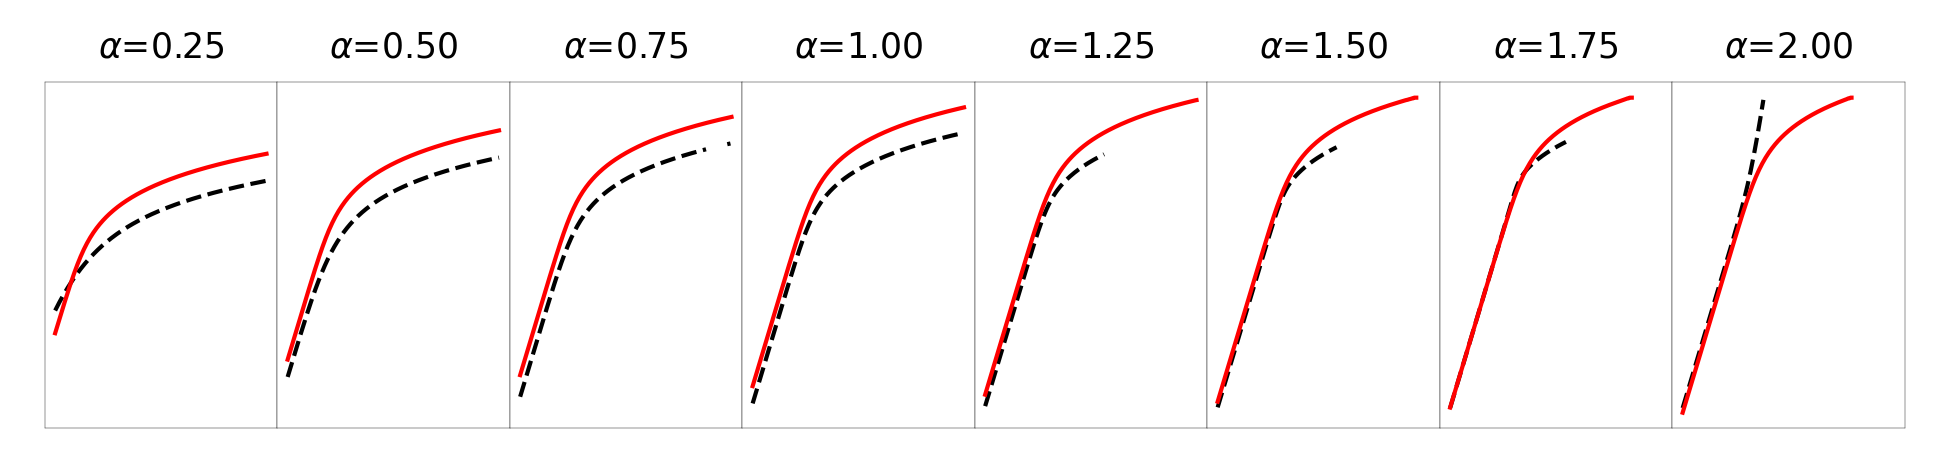

In [12]:
@plot_symmetric
def u_of_x(a, x):
    u = np.tanh(a * np.arcsinh(x / a**2))
    return u

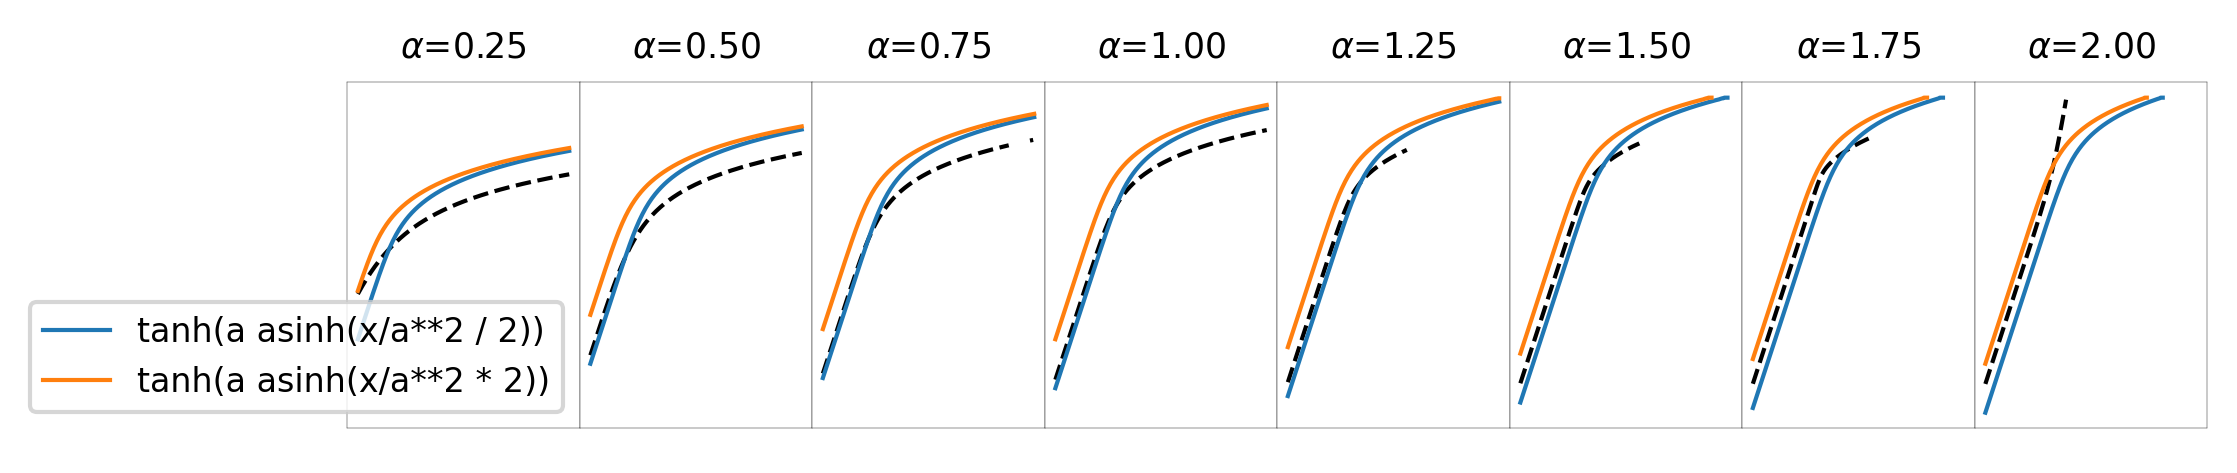

In [13]:
@plot_symmetric
def u_of_x(a, x):
    return {
        "tanh(a asinh(x/a**2 / 2))": np.tanh(a * np.arcsinh(x / a**2 / 2)),
        "tanh(a asinh(x/a**2 * 2))": np.tanh(a * np.arcsinh(x / a**2 * 2)),
    }

Note the peak height of a symmetric stable distribution is approximately `exp(1/a**1.28)`:

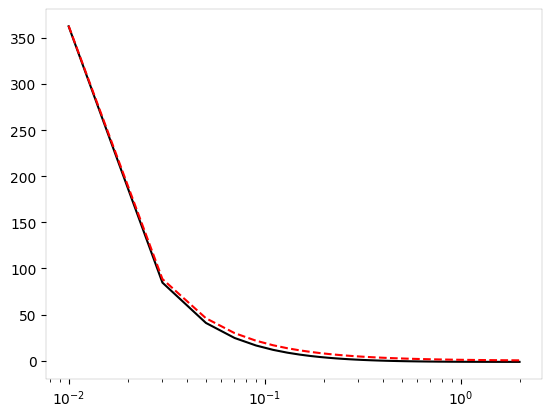

In [14]:
def _(n=100):
    a = np.linspace(1/n, 2, n)
    logp = levy_stable(a, 0).logpdf(0)
    plt.plot(a, logp, "k-")
    plt.plot(a, 1/a**1.28, "r--")
    plt.xscale("log")
_()

What if we try to match peak height with a power series in `a`?

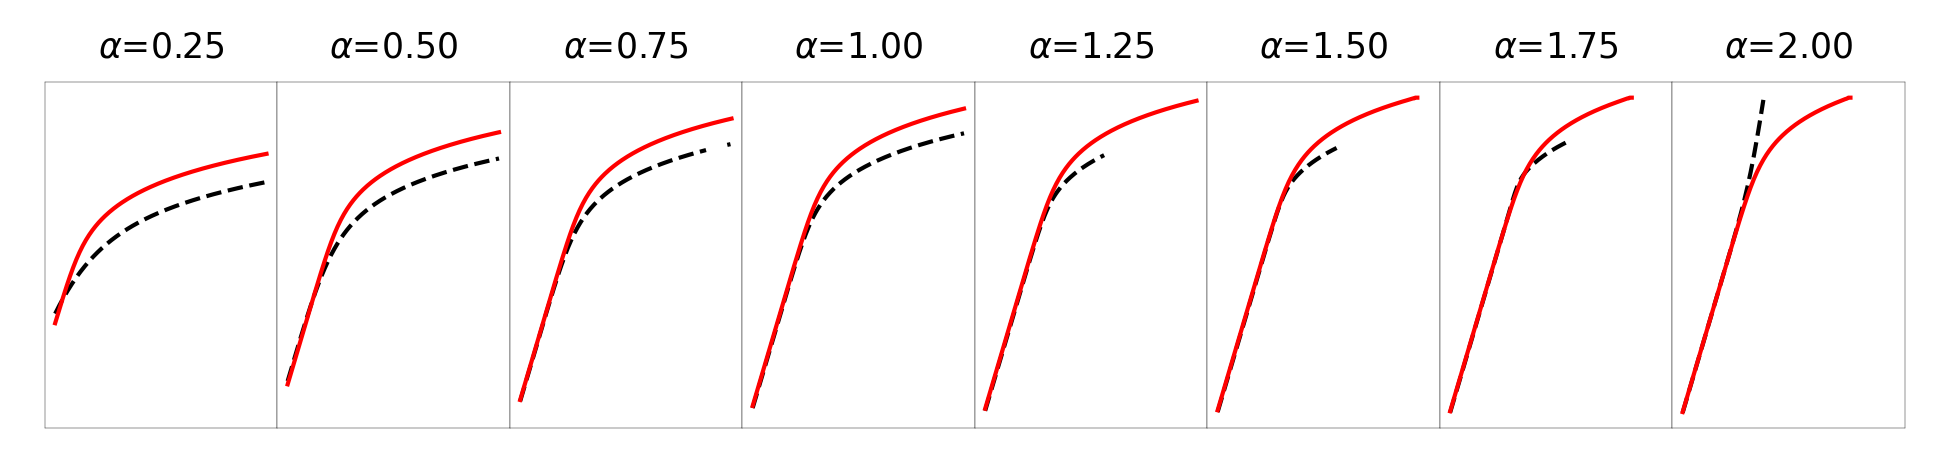

In [15]:
@plot_symmetric
def u_of_x(a, x):
    # these coefficients were hand-optimized:
    u = np.tanh(a * np.arcsinh(x / np.exp(0.3 * a + 1.2 - 1.1 / a)))
    return u

Now what about matching the right asymptote, at least for $\alpha<2$?

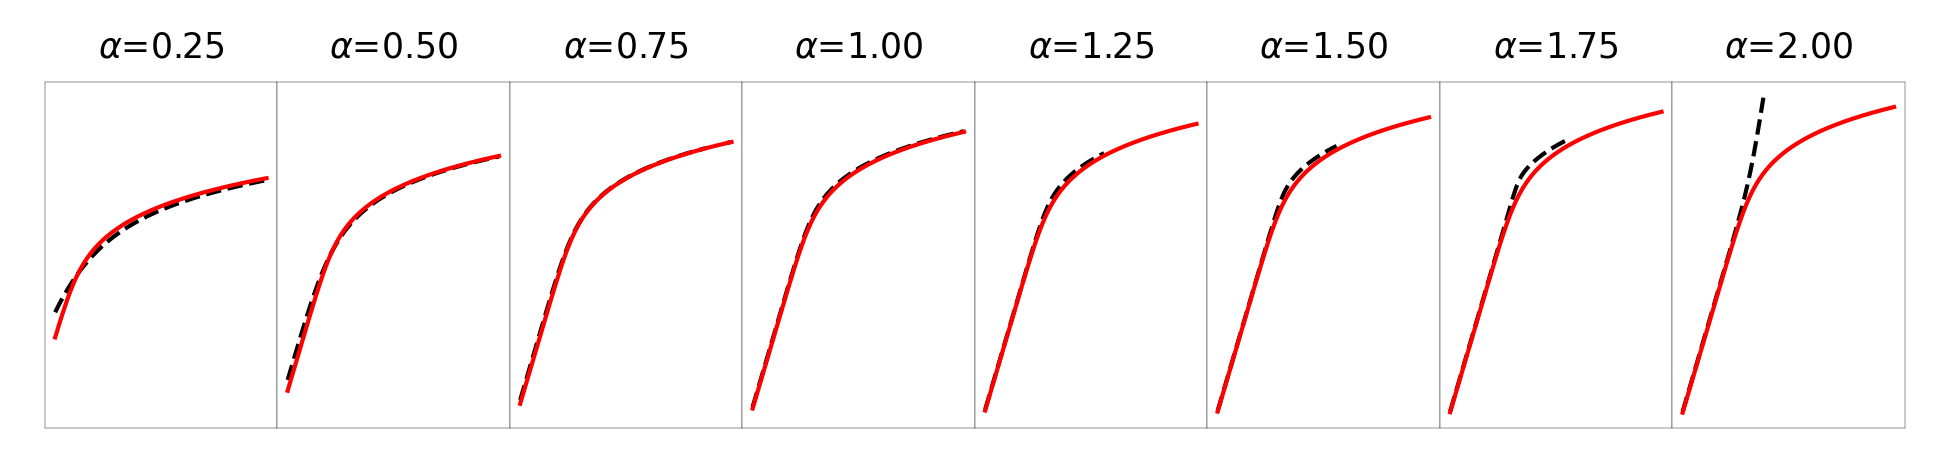

In [16]:
@plot_symmetric
def u_of_x(a, x):
    # these coefficients were hand-optimized:
    u = np.tanh(a / 2 * np.arcsinh(x / np.exp(0.3 * a + 0.5 - 1 / a)))
    return u

### Asymmetric case

In [17]:
def plot_transformed_cdf(u_of_x=None, n=100, eps=1e-3, full=False):
    if u_of_x is None:
        return functools.partial(plot_transformed_cdf, n=n, eps=eps, full=full)
    assert u_of_x.__name__ == "u_of_x"
    x = np.logspace(-2, 5, n // 2)
    x = np.concatenate([np.flip(-x), x])
    b_grid_ = sorted(set(b_grid) | {-b for b in b_grid}) if full else b_grid
    fig, axes = plt.subplots(
        len(b_grid_), len(a_grid), sharex=True, sharey=True,
        figsize=(0.5 + len(a_grid), 0.5 + len(b_grid_)), dpi=300)
    for i, b in enumerate(b_grid_):
        for j, a in enumerate(a_grid):
            u = u_of_x(x, a, b)
            z = S0_to_S1(a, b, x)
            v = levy_stable(a, b).cdf(z)
            ax = axes[i][j]
            ax.plot(u, v, "r-", lw=0.5)
            ax.plot([-1,1], [0,1], 'k--', lw=0.5, zorder=-1)
            ax.axvline(0, lw=0.2, color="k")
            ax.set_xlim(-1, 1)
            ax.set_ylim(0, 1)
            ax.set_xticks(())
            ax.set_yticks(())
            if i == len(b_grid) - 1:
                ax.set_xlabel(f"α = {a:0.3g}")
            if j == 0:
                ax.set_ylabel(f"β = {b:0.3g}")
    plt.subplots_adjust(hspace=0, wspace=0)

Start with the Normal cdf, $\alpha=2$.

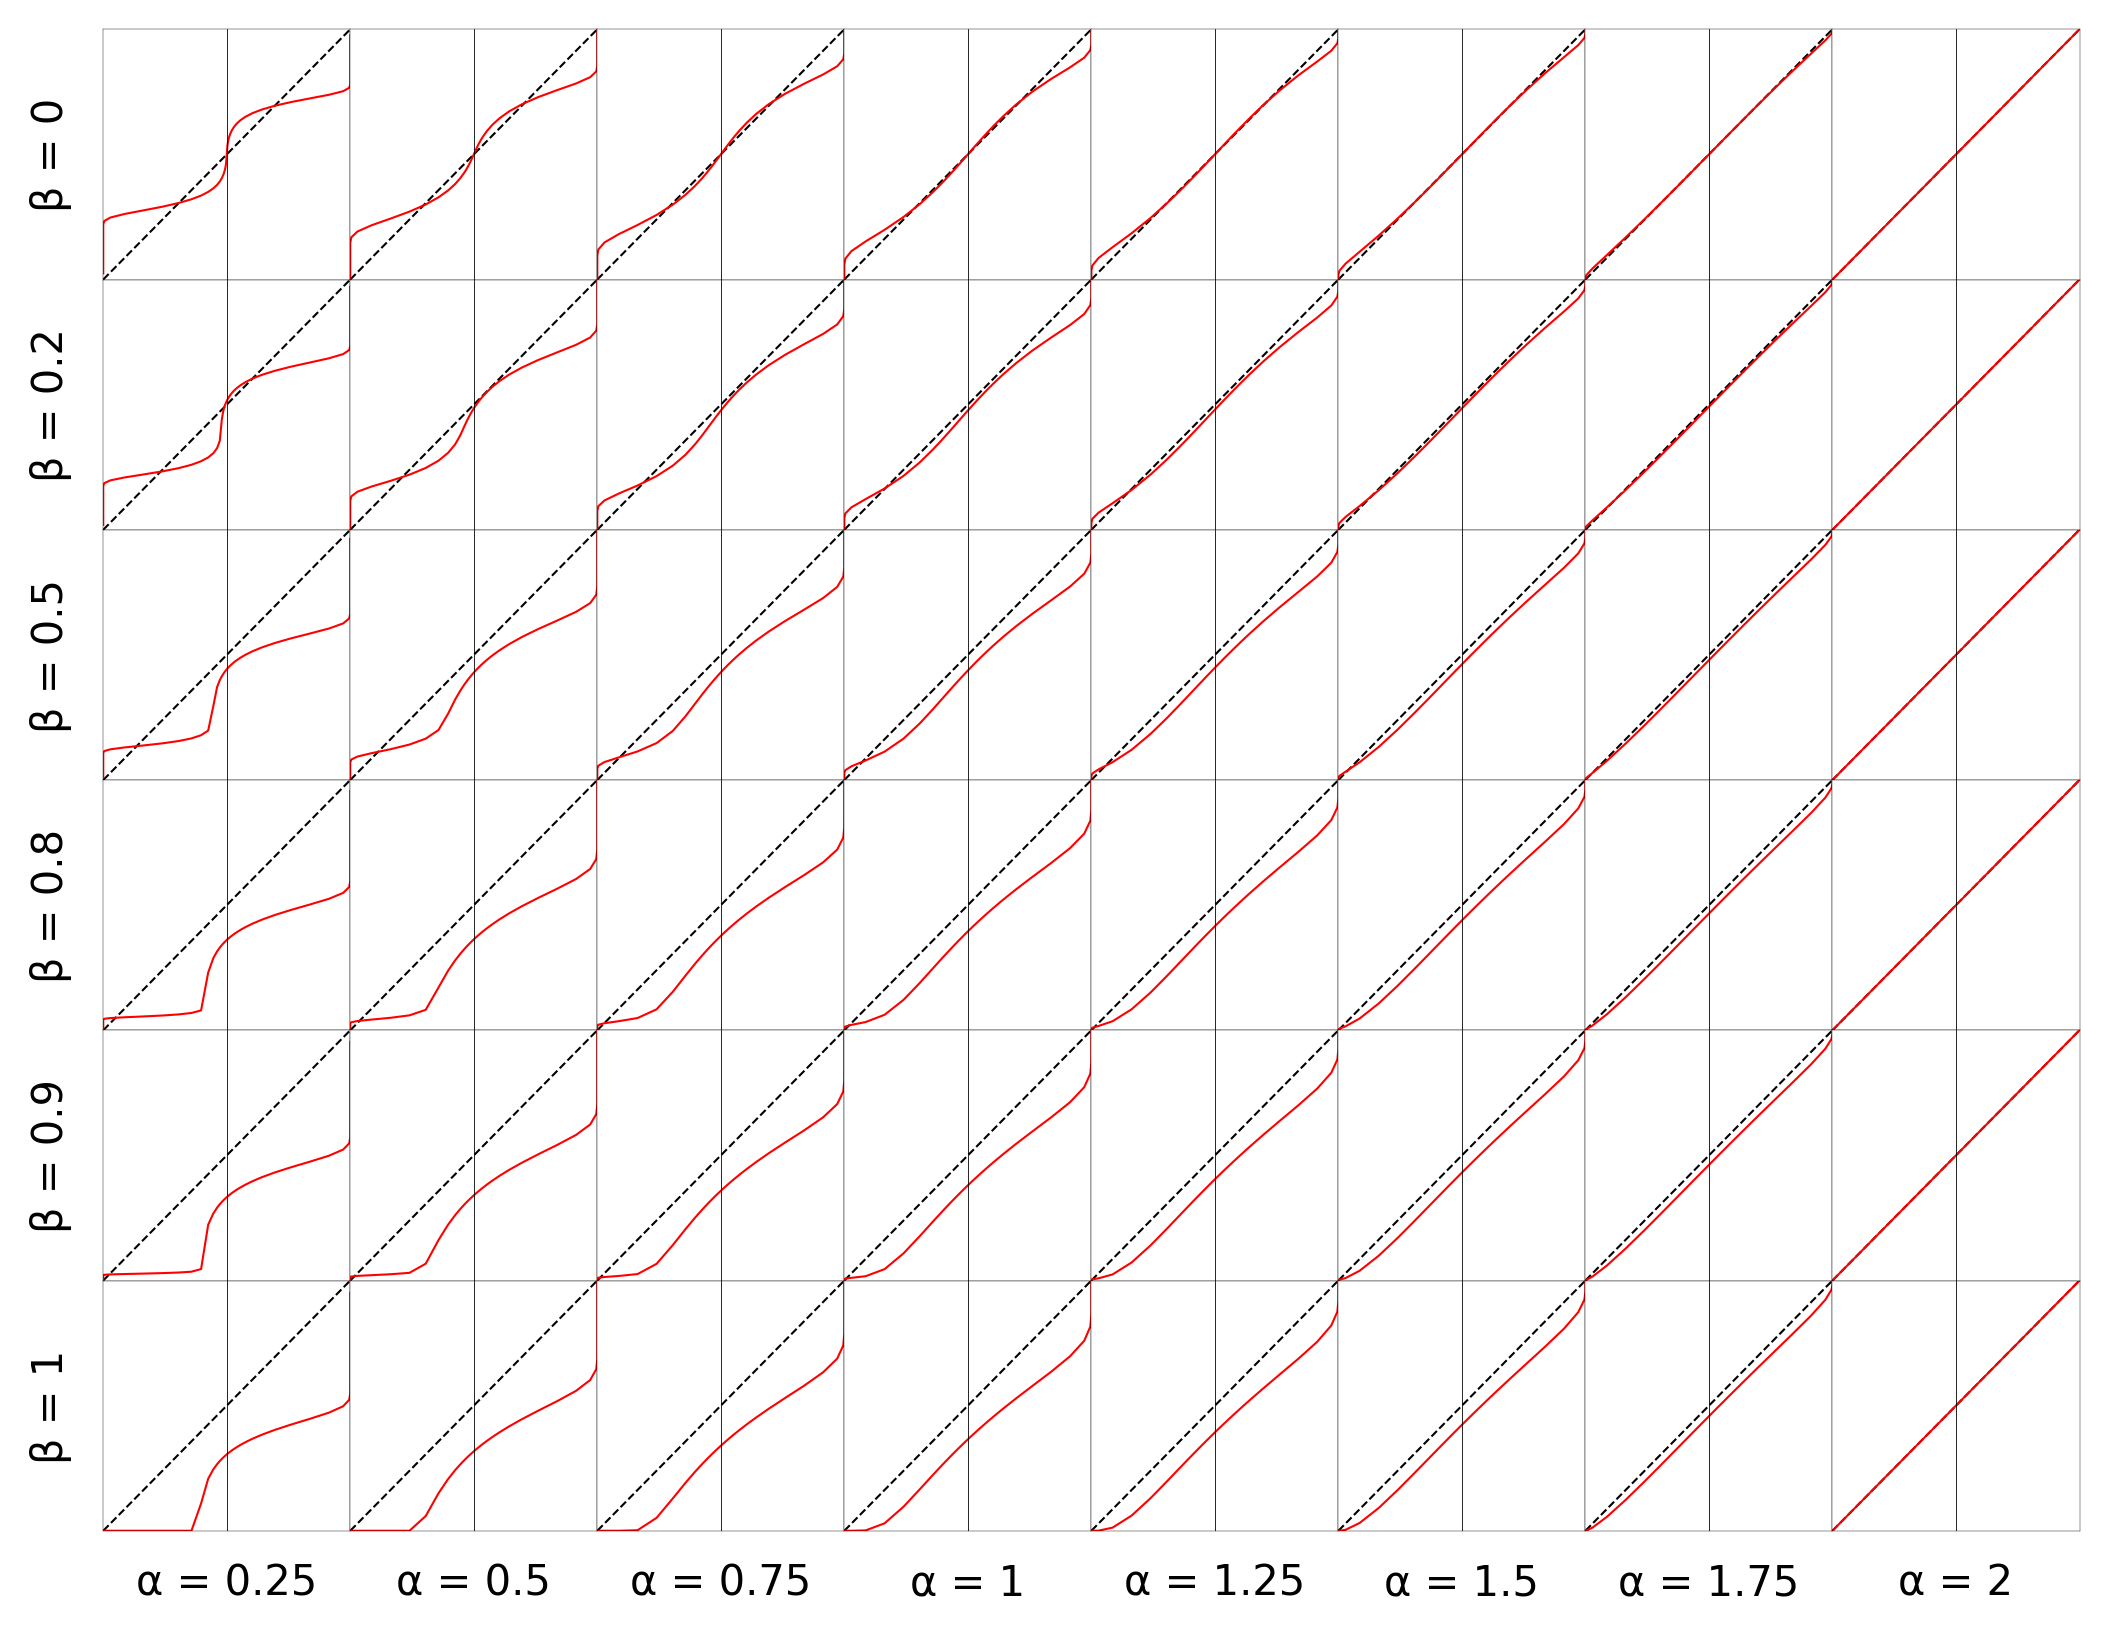

In [18]:
@plot_transformed_cdf
def u_of_x(x, a, b):
    u = scipy.special.erf(x / 2)
    return u

And the two asymptotes:

/var/folders/b1/wvrl7j3566v_xfhch9qf76d80000gn/T/ipykernel_59911/4146912236.py:5: RuntimeWarning: invalid value encountered in divide
  return 1 - 2 * ca * (1 + b) / sx**a
/var/folders/b1/wvrl7j3566v_xfhch9qf76d80000gn/T/ipykernel_59911/4146912236.py:5: RuntimeWarning: overflow encountered in divide
  return 1 - 2 * ca * (1 + b) / sx**a


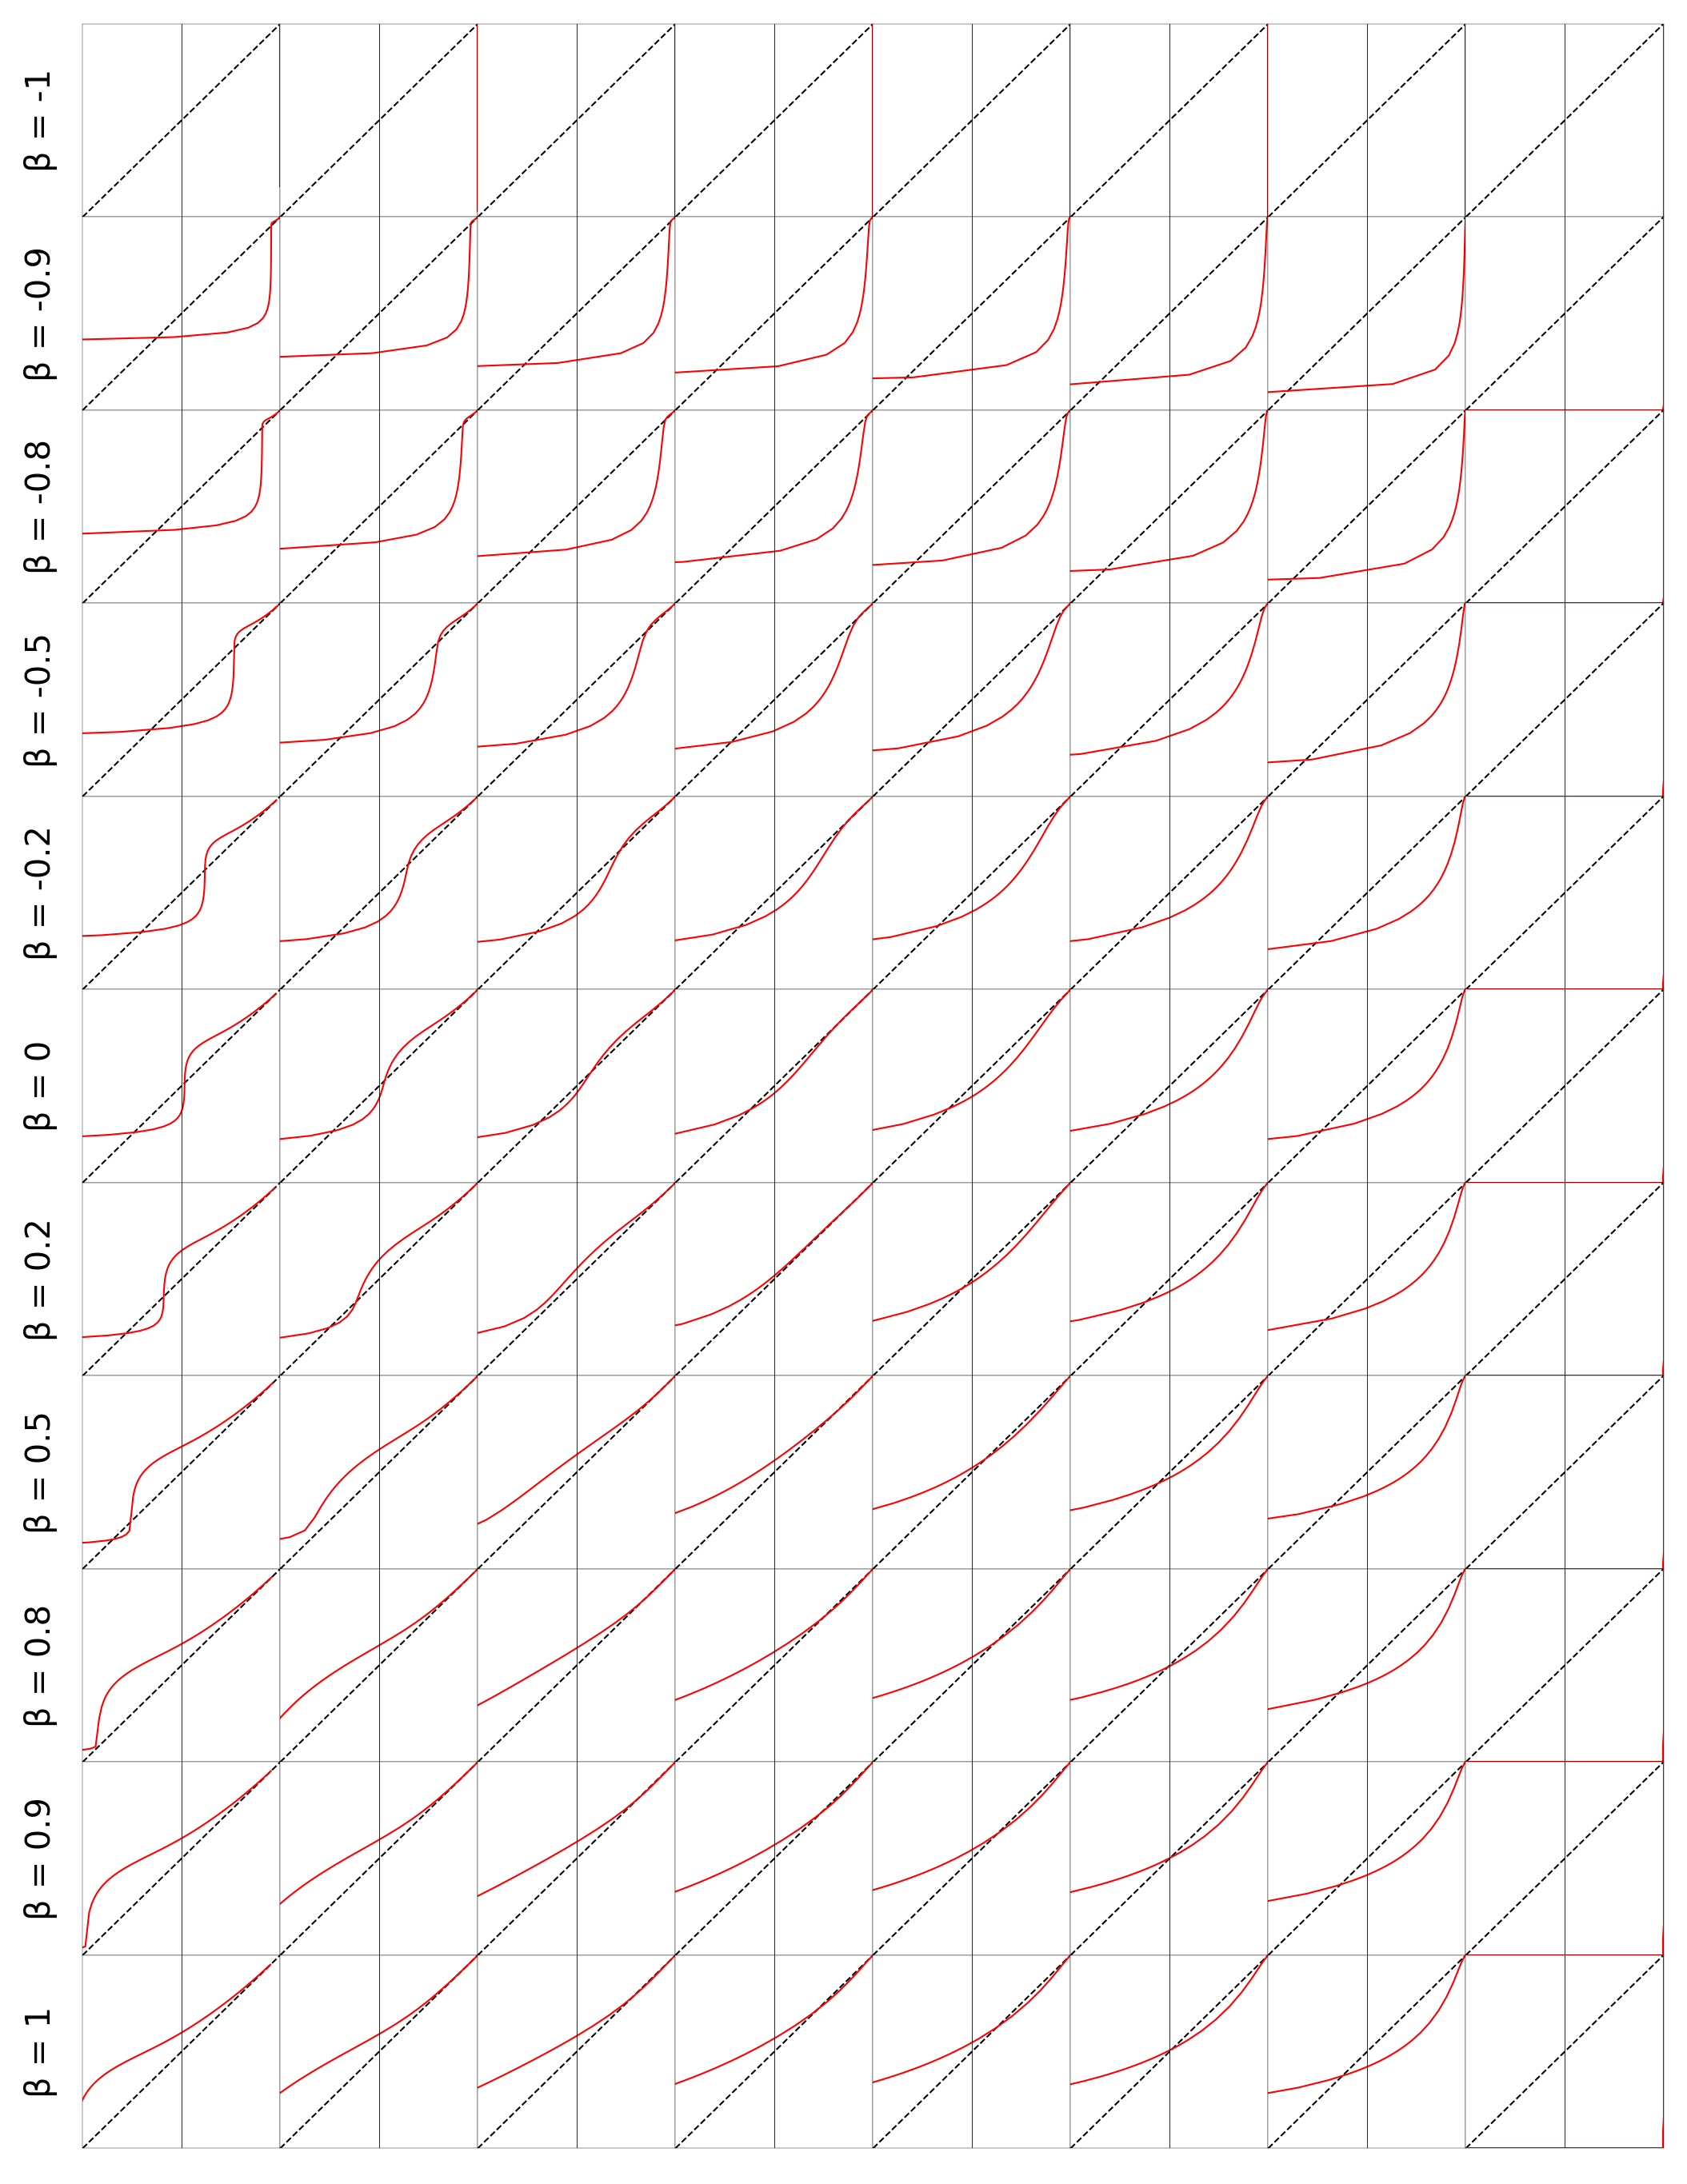

In [19]:
@plot_transformed_cdf(full=True)
def u_of_x(x, a, b):
    ca = np.sin(np.pi * a / 2) * scipy.special.gamma(a) / np.pi
    sx = torch.nn.functional.softplus(torch.tensor(x)).numpy()
    return 1 - 2 * ca * (1 + b) / sx**a

/var/folders/b1/wvrl7j3566v_xfhch9qf76d80000gn/T/ipykernel_59911/4238851753.py:5: RuntimeWarning: invalid value encountered in divide
  return np.exp(-ca * (1 + b) / sx**a) * 2 - 1
/var/folders/b1/wvrl7j3566v_xfhch9qf76d80000gn/T/ipykernel_59911/4238851753.py:5: RuntimeWarning: overflow encountered in divide
  return np.exp(-ca * (1 + b) / sx**a) * 2 - 1


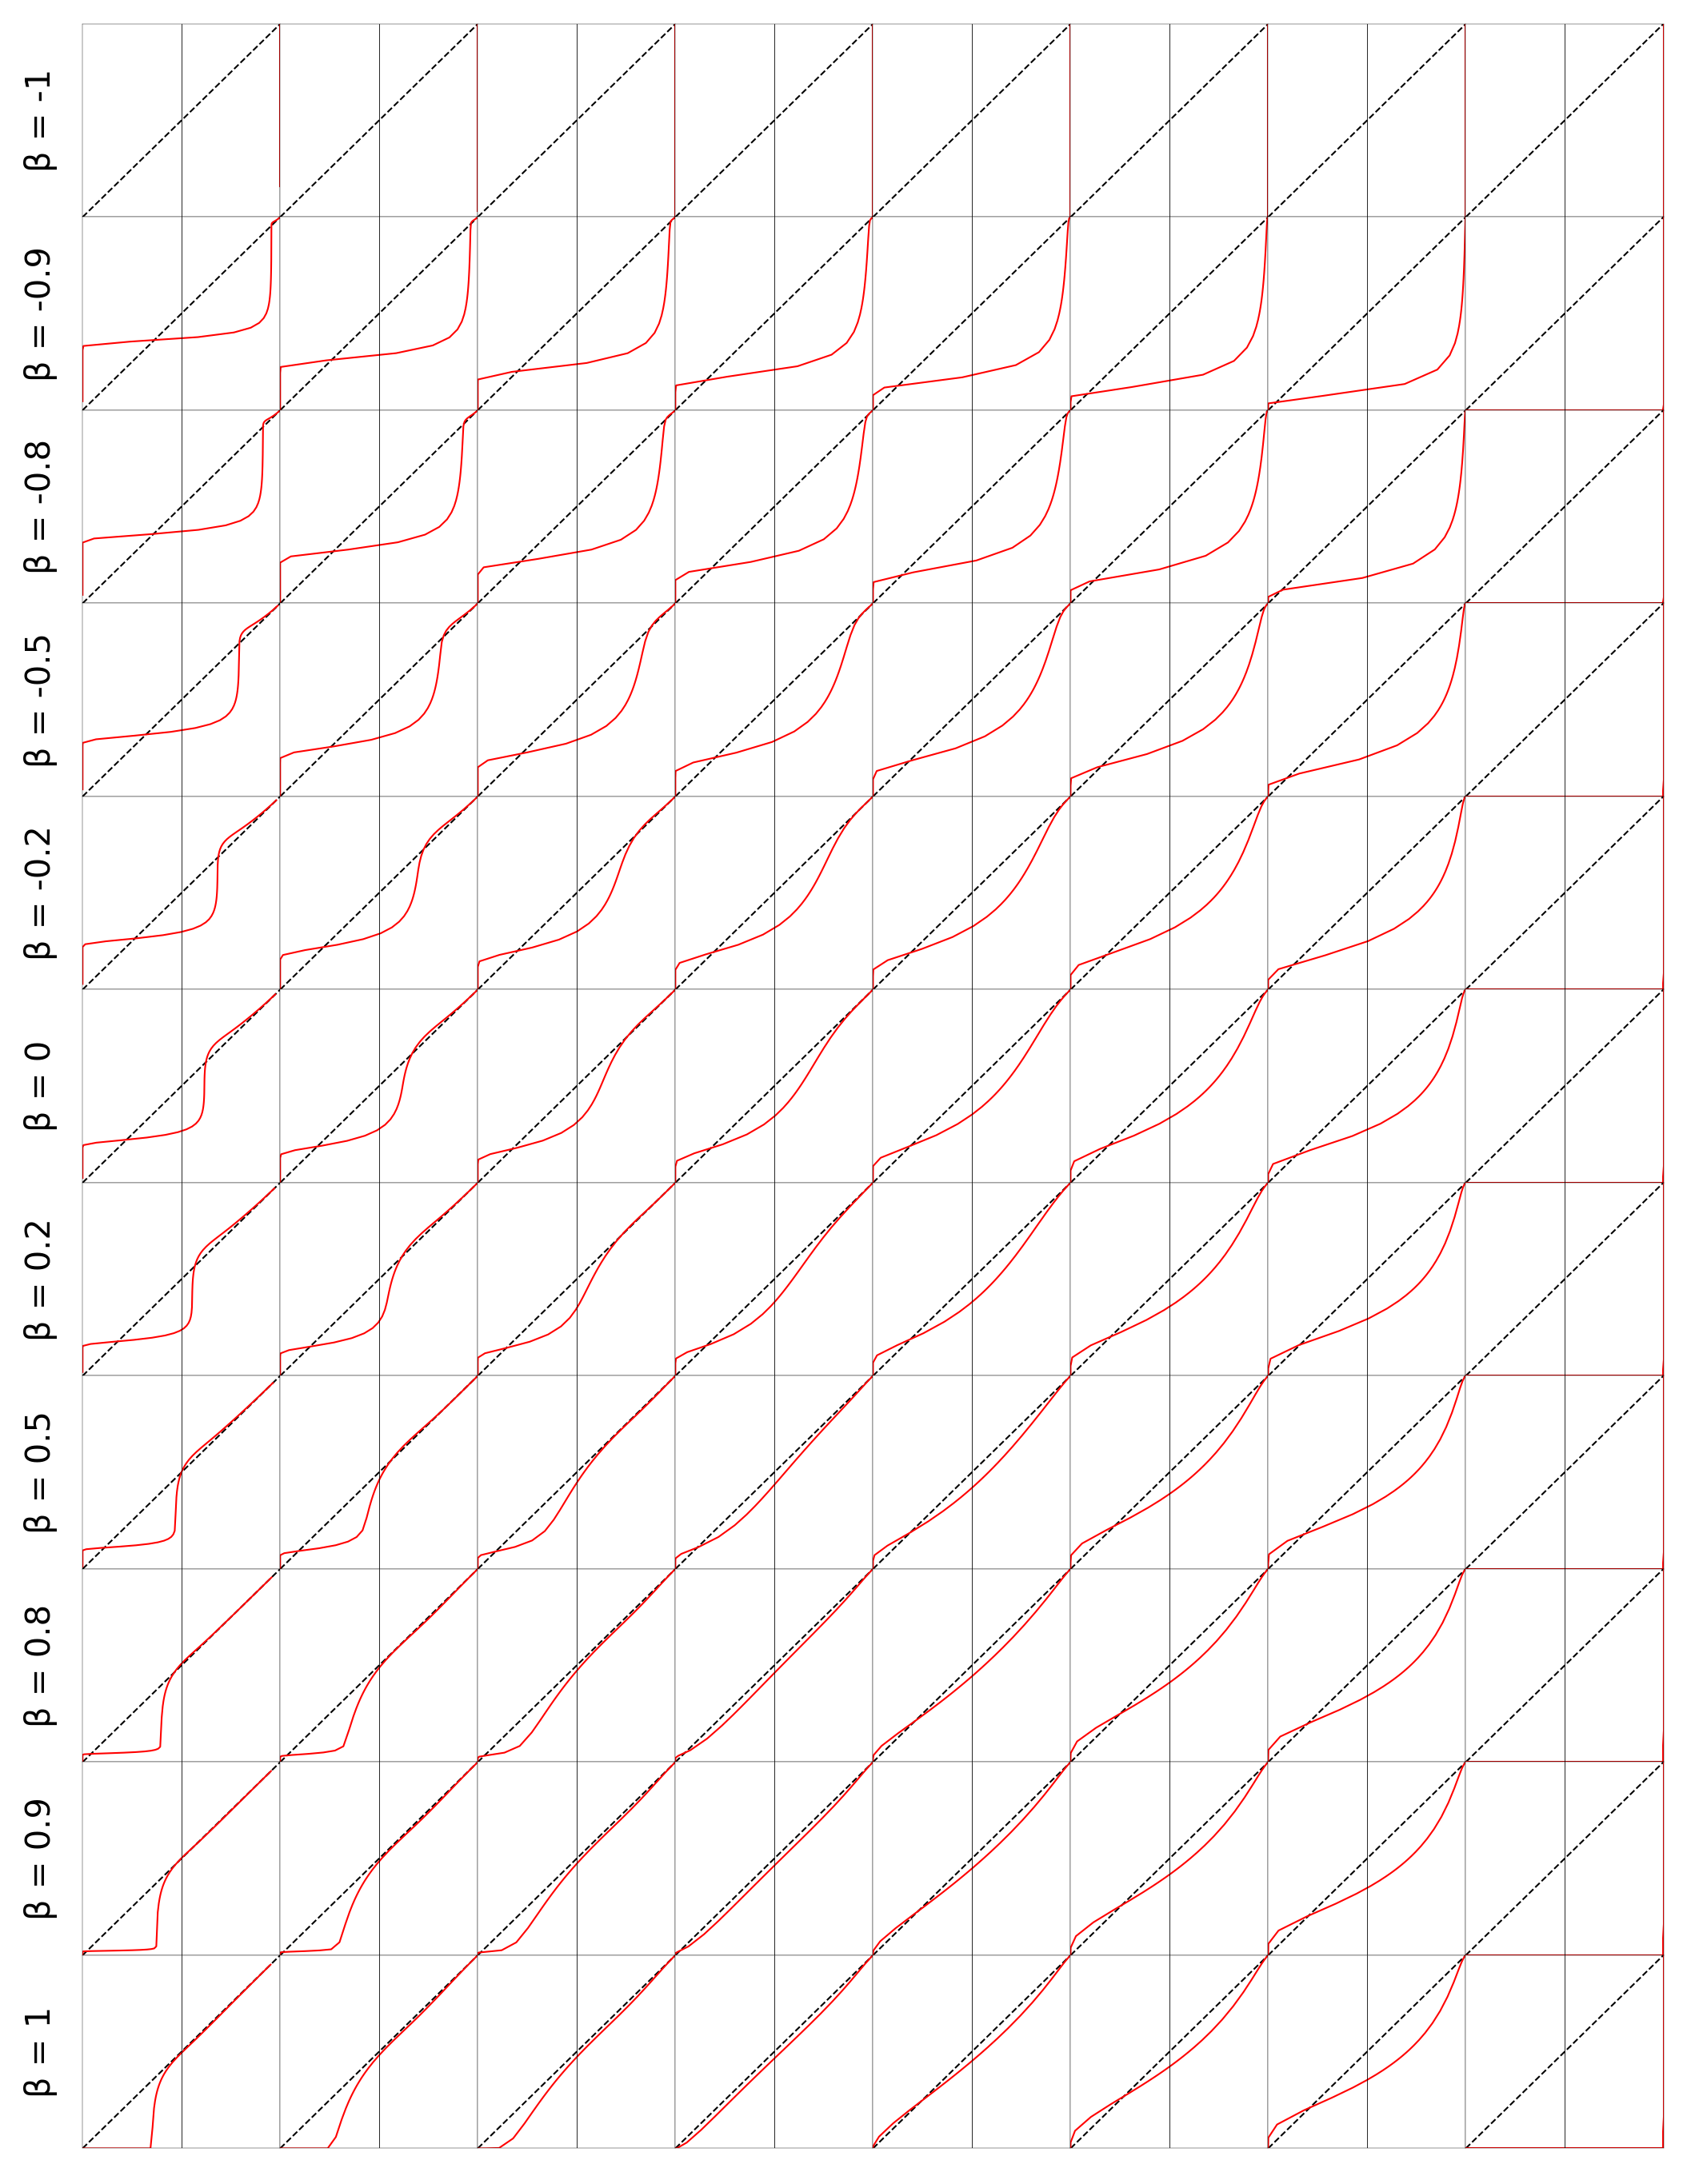

In [20]:
@plot_transformed_cdf(full=True)
def u_of_x(x, a, b):
    ca = np.sin(np.pi * a / 2) * scipy.special.gamma(a) / np.pi
    sx = torch.nn.functional.softplus(torch.tensor(x)).numpy()
    return np.exp(-ca * (1 + b) / sx**a) * 2 - 1

## Learning an approximation

Next let's try learning an approximation. We'll minimize RMS error of the CDF, sampling uniform random values of $\alpha\in[\frac 1 2,2]$, $\beta\in[-1,1]$ and sampling sampling `atanh(x)` uniformly in $[-1,1]$.

Recall the three asymptotes of the cdf:
\begin{align*}
\text{As }\alpha\nearrow 2\!:&\quad
  u(x) \approx \operatorname{erf}(x/2)
\\
\text{As }x\nearrow\infty\!:&\quad
  u(x) \approx 1 - 2 c_\alpha(1+\beta)x(u)^{-\alpha}
\\
\text{As }x\searrow-\infty\!:&\quad
  u(x) \approx 2 c_\alpha(1-\beta)(-x(u))^{-\alpha} - 1
\end{align*}
where
$$
c_\alpha = \sin\left(\frac {\pi\alpha} 2\right) \frac {\Gamma(\alpha)} \pi
$$

In [67]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.coef = torch.nn.Parameter(torch.zeros(5, 5, 5, 3))
        print(f"model has {self.coef.numel()} parameters")

    def forward(self, a, b, x) -> torch.Tensor:  # aka u_of_x
        ca = torch.sin(np.pi * a / 2) * torch.lgamma(a).exp() / np.pi  # in [0,1/2]
        x_pos = torch.nn.functional.softplus(x)
        x_neg = torch.nn.functional.softplus(-x)
        u_left = torch.exp(-ca * (1 + b) / x_pos**a) * 2 - 1
        u_right = 1 - 2 * torch.exp(-ca * (1 - b) / x_neg**a)
        u_light = torch.erf(x / 2)
    
        def inv(t):
            return t.clamp(min=torch.finfo(t.dtype).eps).reciprocal()
        one = torch.ones_like(x)
        tma = 2 - a
        ix = inv(1 + x.square())
        a_features = torch.stack([one, tma, tma**2, inv(a), inv(tma)], -1)
        b_features = torch.stack([one, b, b**2, inv(1 - b), inv(1 + b)], -1)
        x_features = torch.stack([one, x * ix, ix, x_neg, x_pos], -1)
        logits = torch.einsum(
            "...a,...b,...x,abxc->...c", a_features, b_features, x_features, self.coef
        )
        w0, w1, w2 = logits.softmax(-1).unbind(-1)
        u = w0 * u_light + w1 * u_left + w2 * u_right
        return u
    
    def cdf(self, a, b, x):
        u = self(a, b, x)
        return (u + 1) / 2
    
    def cdf_and_pdf(self, a, b, x, dx):
        """Computes CDF and PDF by finite difference"""
        xx = torch.stack([x - dx, x + dx])
        aa = a.expand_as(xx)
        bb = b.expand_as(xx)
        neg, pos = self.cdf(aa, bb, xx)
        cdf = (neg + pos) / 2
        pdf = (pos - neg) / (2 * dx)
        return cdf, pdf

    @staticmethod
    @torch.no_grad()
    def S0_to_S1(a, b, x):
        return torch.where(a == 1, x, x + b * torch.tan(np.pi / 2 * a))

model has 375 parameters


  0%|          | 0/1001 [00:00<?, ?it/s]

step 0 loss = nan
step 100 loss = 0.162
step 200 loss = 0.153
step 300 loss = 0.134
step 400 loss = 0.156
step 500 loss = 0.124
step 600 loss = 0.115
step 700 loss = 0.187
step 800 loss = 0.173
step 900 loss = 0.0921
step 1000 loss = 0.163


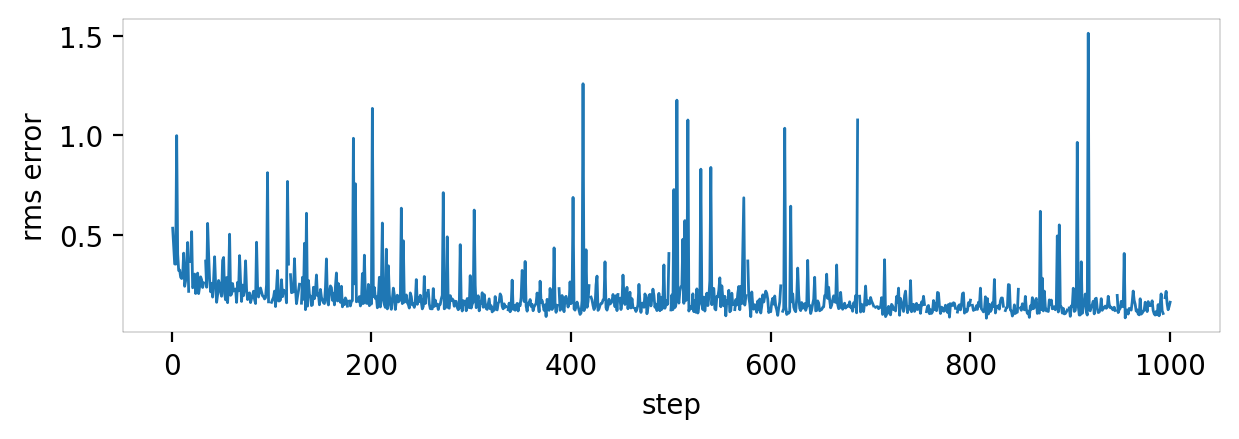

In [83]:
def train(batch_size=32, a_min=0.5, num_steps=1001, lr=1e-3, lrd=0.1, order=1):
    assert batch_size % 2 == 0
    torch.manual_seed(123)
    model = Model()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.995))
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=lrd**(1 / num_steps))
    quasirand = torch.quasirandom.SobolEngine(dimension=5)
    losses = []
    for step in tqdm(range(num_steps)):
        optimizer.zero_grad()
        rand = quasirand.draw(batch_size).T.contiguous()
        x = rand[0].mul_(2).sub_(1).atanh_()
        a = rand[1].mul_(2 - a_min).add_(a_min)
        b = rand[2].mul_(2).sub_(1)
        
        z = Model.S0_to_S1(a, b, x)
        cdf_true = torch.tensor(levy_stable(a.numpy(), b.numpy()).cdf(z.numpy()))
        if order == 0:
            cdf_pred = model.cdf(a, b, x)
        else:
            pdf_true = torch.tensor(levy_stable(a.numpy(), b.numpy()).pdf(z.numpy()))
            dx = 1e-4 / pdf_true
            cdf_pred, pdf_pred = model.cdf_and_pdf(a, b, x, dx)
        
        loss = (cdf_true - cdf_pred).square().mean().sqrt()
        if order:
            logp_pred = (pdf_pred + 1e-6).log()
            logp_true = (pdf_true + 1e-6).log()
            loss = loss + (logp_pred - logp_true).square().mean().sqrt()
        losses.append(loss.item())
        if step % 100 == 0:
            print(f"step {step} loss = {loss.item():0.3g}")
        loss.backward()
        for p in model.parameters():
            if p.grad is not None:
                p.grad.clamp(min=-100, max=100)
                p.grad[~p.grad.isfinite()] = 0
        optimizer.step()
    plt.figure(figsize=(6,2), dpi=200)
    plt.plot(losses, lw=1)
    plt.xlabel("step")
    plt.ylabel("rms error")
    plt.tight_layout(pad=0)
    return model
        
model = train()

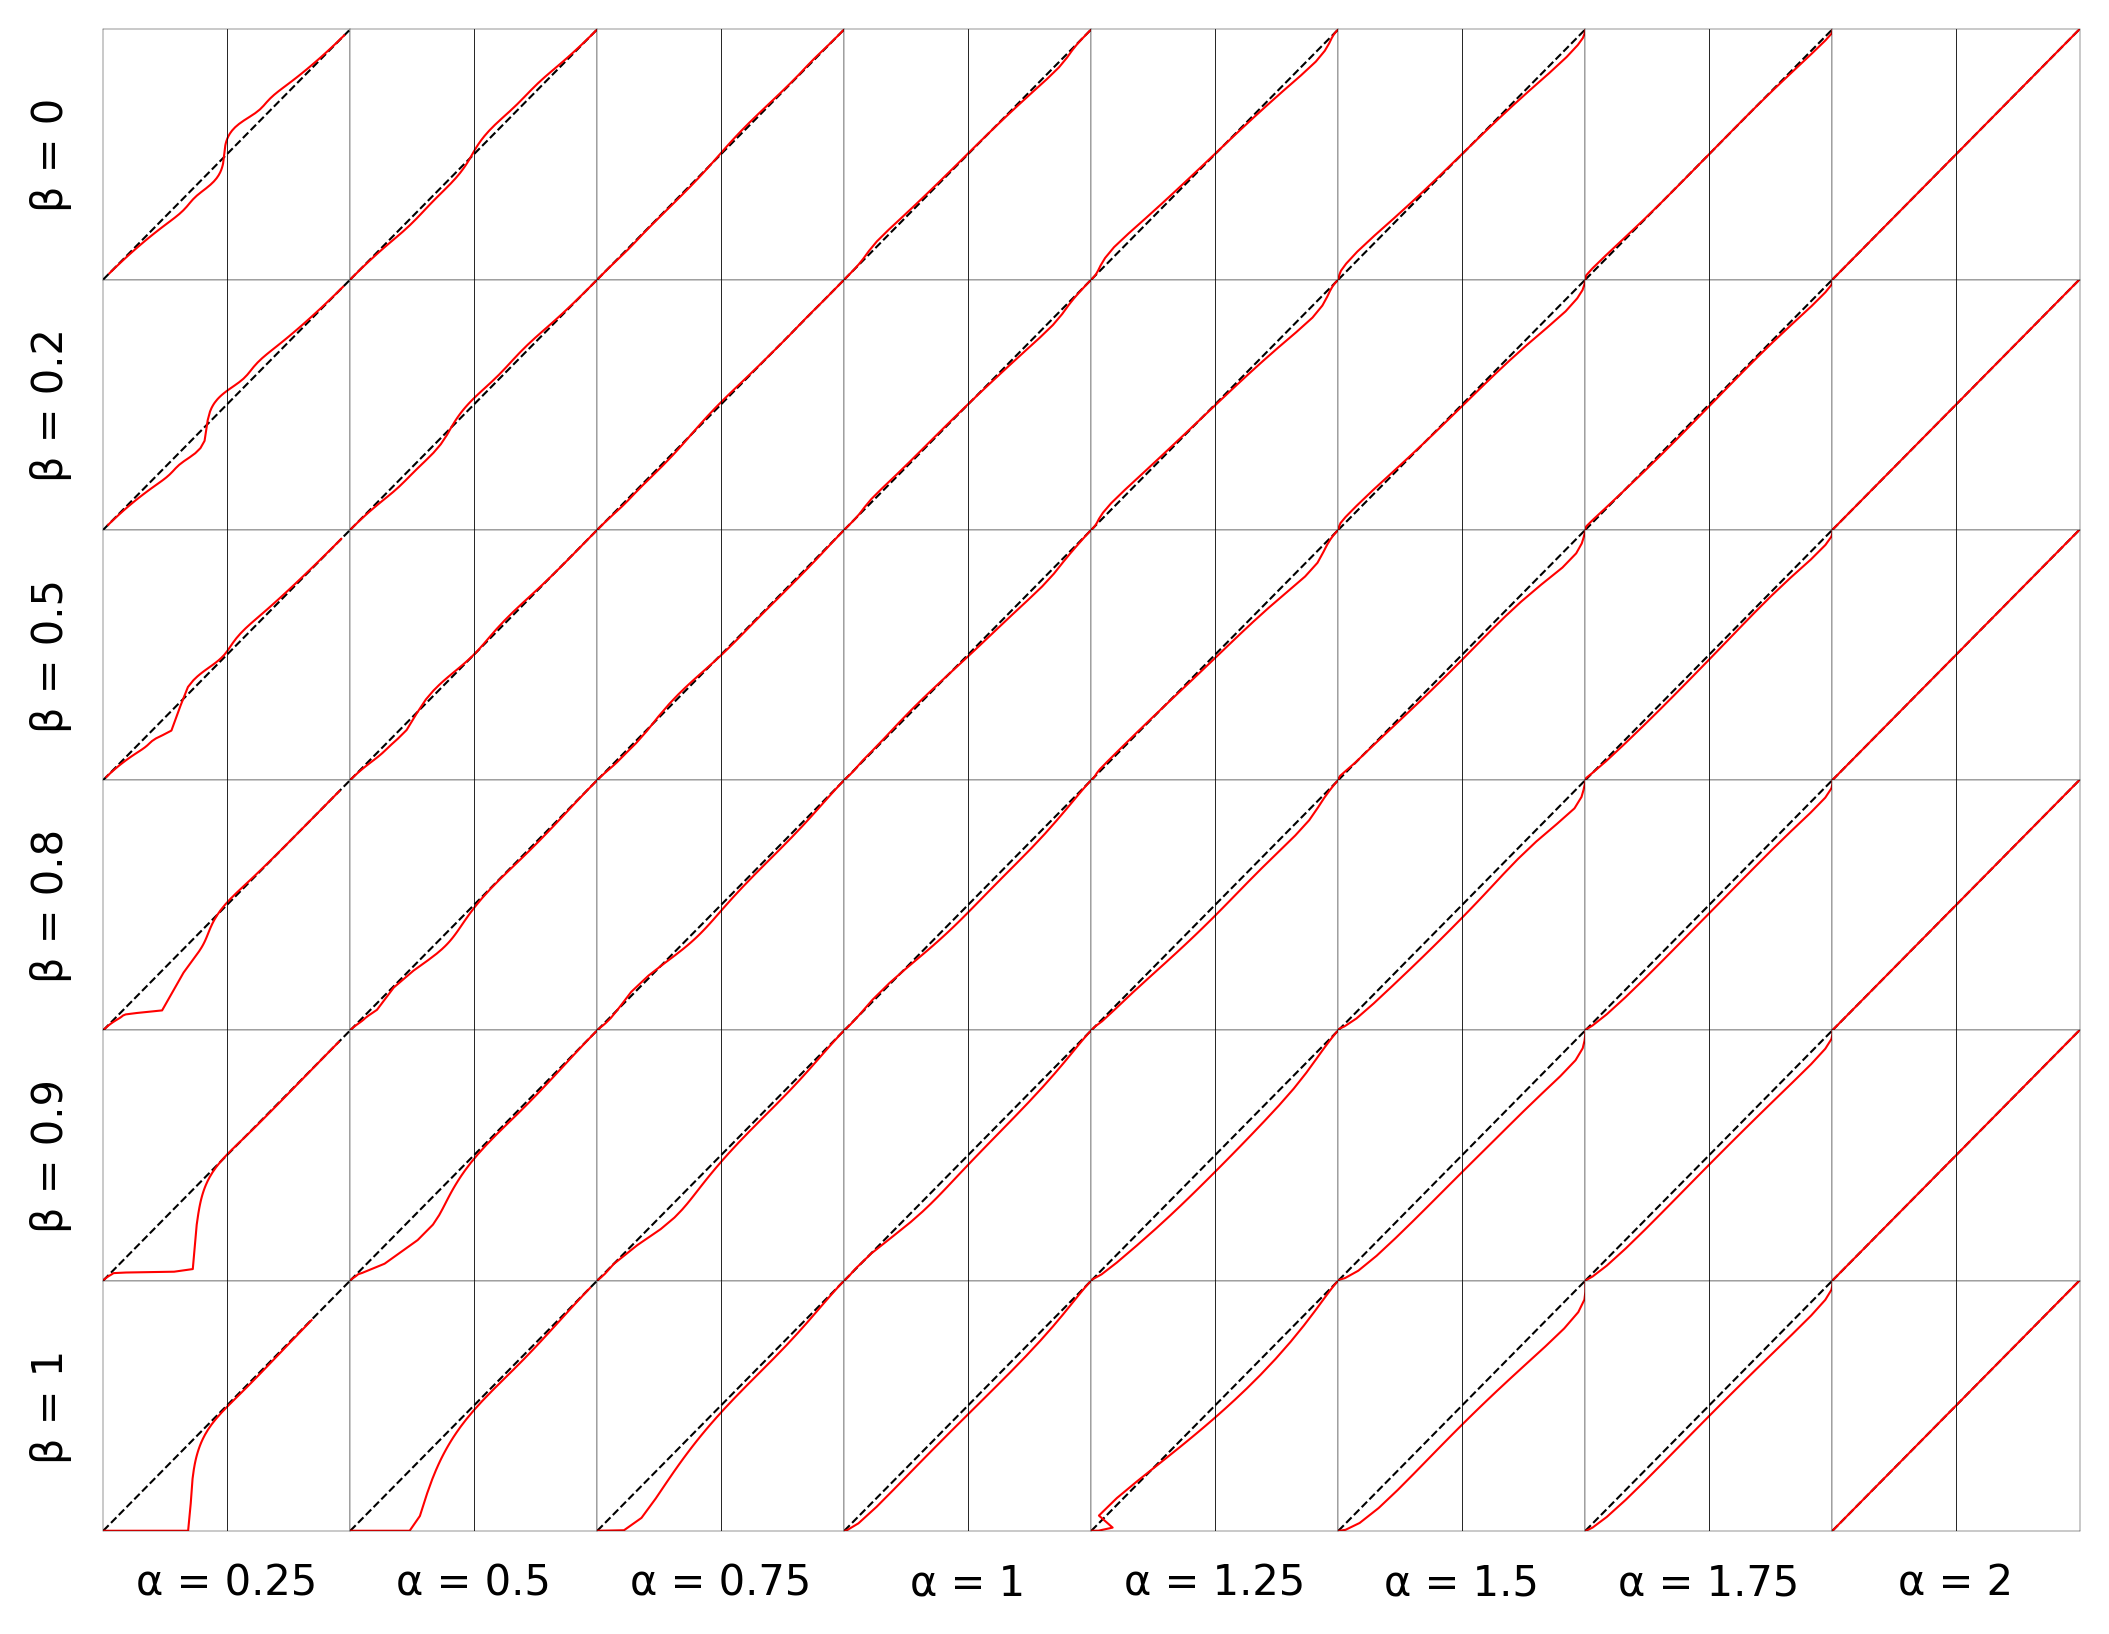

In [84]:
@plot_transformed_cdf
@torch.no_grad()
def u_of_x(x, a, b):
    x = torch.tensor(x)
    a = torch.tensor(a)
    b = torch.tensor(b)
    x, a, b = torch.broadcast_tensors(x, a, b)
    u = model(a, b, x)
    return u.numpy()